# Provasi Matteo (782922)

# Assignment 2

## Consegna
<br>
<font size=3>
    

Data un'immagine:
1. Calcola LBP sull'intera immagine
2. La scompone in blocchi (cosa utile avere blocchi sovrapposti), il primo dovrà condividere dei pixel con il secondo; è stato dimostrato che includere più volte la parte di un immagine in descrittori diversi aumenta le performance.
3. Calcolare un istogramma di LBP, non per l'intera immagine ma per ciascun blocco

In [1]:
import os
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
from skimage import feature
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from time import time
from tqdm import tqdm

base_path = "C:/path/"

<font size=3>
    
La funzione <b>load_data</b> legge le immagini nelle cartelle presenti nella directory e una volta caricatapassa l'immagine alla funzione <b>lbp_features</b> che effettua un local binary patteri. I parametri immessi nella funzione vera e propria di LBP (<b>feature.local_binary_pattern</b>) sono:
* <b>img</b>: l'immagine letta su cui viene fatto il LBP
* <b>P</b>: il numero di punti da considerarare
* <b>R</b>: il raggio su cui cercare i vicini
* <b>method</b>: messo su <i>uniform</i> versione migliorara del metodo di defaul che è invariante per rotazione.

<br></br>
Come espresso nella richiesta dell'esercizio, il LBP deve essere calcolato non sull'intera immagine ma su blocchi (sovrapposti) dato che seguendo questo metodo si ha un miglior input per la futura classificazione. In aggiunta nella funzione creata sono stati aggiunti i seguenti parametri:
* <b>y_shift</b>: la dimensione dello slide della finestra sull'asse y
* <b>x_shift</b>: come il precedente sull'asse x
* <b>size</b>: è la dimensione della finestra. Questo valore per far sì che si prendano blocchi sovrapposti deve essere strattamente maggiore dei due valori precedenti.

<br></br>
Trovata la finestra, si calcola l'istogramma sulla porzione di immagine selezionata e l'output è salvato in una lista. La funzione restituisce un array di tutti gli elementi creati nelle iterazioni.

<br></br>
Ritornando alla funzione <b>load_data</b> questi valori di output saranno le feature che serviranno per la classificazione, nella successiva riga vengnono salvati i label che indicano la classe di appartenenza dell'immagine. Come ultimo step attraverso la funzione <b>train_test_split</b> sono creati i "dataset" di train e test partendo dalle feature e le rispettive label. 

In [2]:
def load_data(feature_extractor, maximages=100):
    labels = []
    features = []
    
    for di, d in enumerate(sorted(os.listdir(base_path))):
        for fi, f in enumerate(sorted(os.listdir(base_path + d + '/'))):
            
            if f.endswith('.jpg') and fi < maximages:
                image = cv.imread(base_path + d + '/' + f, 0)
                cur_features = feature_extractor(image)
                features.append(cur_features)
                labels.append(di)
                
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=0)
    return X_train, X_test, y_train, y_test


def lbp_features(img, P=24, R=8, y_shift=8, x_shift=8, size=16):
    img = feature.local_binary_pattern(img, P=P, R=R, method='uniform')
    feats = []
    
    for y in range(0, img.shape[0], y_shift):
        for x in range(0, img.shape[1], x_shift):
            
            block = img[y:(y+size), x:(x+size)]
            hist = np.bincount(block.flatten().astype(int), minlength=P+2)
            feats.append(hist)
            
    return np.array(feats)

<font size=3>
    
Nella funzione <b>bow</b> si prendono i descrittori che sono stati messi in una lista per ogni immagine e li si concatenano in un'unica lista  mediante <b>np.concatenate</b>. <br></br> 
L'obiettivo di questa funzione è quello di trovare un insieme di "parole" che mi descrivano l'immagine, in sostanza un conteggio delle feature che definiscono l'immagine. Per costruire il vocabolario viene utilizzato un algoritmo di clustering <b>MiniBatchKMeans</b>, in quest esempio kmeans. Una delle limitazione di questo algoritmo è che l'utente deve definire il numero di cluster come input dell'algoritmo. Non esiste un numero corretto di parole, ma la quantità varia a seconda del problema. Una possibile via è quella di ricavare questo numero dal numero medio di descrittori delle immagini. <br></br>
Per avere risultati migliori si effettua una normalizzazione delle feature prima del kmeans. Dopo aver trovato i cluster, tramite la funzione <b>bow_feature</b>, ogni feature di ogni singola viene associata ad uno dei centroidi. Come passo finale gli istogrammi vengnon normalizzati in modo tale che sommino a $1$. Questo passaggio sarà utile al classificatore nel passaggio successivo.

In [3]:
def bow_features(feats, dictionary, nwords):
    quantized = dictionary.predict(feats)
    t = np.bincount(quantized, minlength=nwords)
    return t


def bow(X_train, X_test, nwords=0, normalize=True):
    X_train_stack = np.zeros((0,X_train[0].shape[1]), dtype=np.float32)
    for t in X_train:
        X_train_stack = np.concatenate((X_train_stack, t))
        
    if nwords == 0:
        nwords = int(np.mean([desc.shape[0] for desc in X_train]) / 10)
    if nwords > 300:
        nwords = 300
        
    if normalize:
        eps = 0.001
        X_train_mean = X_train_stack.mean(axis=0)
        X_train_std = X_train_stack.std(axis=0)
        X_train = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_train]
        X_test = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_test]
        X_train_stack = (X_train_stack - X_train_mean + eps)/(X_train_std + eps)
        
    dictionary = MiniBatchKMeans(n_clusters=nwords)
    dictionary.fit(X_train_stack)
    
    X_train = [bow_features(f, dictionary, nwords) for f in X_train]
    X_test = [bow_features(f, dictionary, nwords) for f in X_test]
    X_train = [hist/hist.sum() for hist in X_train]
    X_test = [hist/hist.sum() for hist in X_test]
    
    return X_train, X_test

In [4]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=lbp_features, maximages=500)

In [5]:
X_train2, X_test2 = bow(X_train, X_test, nwords=300)

<font size=3>

Si cercano di classificare gli istogrammi tramite un modello di classificazione, in questo caso una <b>SVM</b>. Per ottenere delle performance classificative miglori si effettua una ricerca di parametri tramite <b>GridSearchCV</b>: dati dei parametri in input, questa funzione prova tutte le combinazioni possibili di parametri, effettua una classificazione tramite cross-validazione e restituisce il set di parametri migliore. <br></br>
Il modello è costruito utilizzando un kernel <i>rbf</i>, i parametri su cui si effettua la ricerca sono:
* <b>C</b>: è una parametro che indica quanto un modello deve essere penalizzato per aver classificato erroneamente delle osservazioni, più è alto più viene penalizzato.
* <b>gamma</b>: indica come si deve adattare la decision boundary creata dal modello: con valori bassi la linea di decisione tende ad essere molto semplice, più vicino alla linearità, al contrario più il valore aumenta più diventa articolata rischiando però di specializzarsi troppo arrivando ad avere overfitting.

In [6]:
param_grid = {'C': [0.5, 1, 1.5, 2],
              'gamma': [0.1, 1, 10, 100, 300]} 

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=1)

t2 = time()
clf = clf.fit(X_train2, y_train)
print("Addestramento completato in %0.3fs" % (time() - t2))

print("Migliore combinazione di parametri:")
print(" C: "+ str(clf.best_estimator_.C))
print(" gamma: "+ str(clf.best_estimator_.gamma))

Addestramento completato in 30.979s
Migliore combinazione di parametri:
 C: 2
 gamma: 300


<font size=3>

Il modello migliore viene applicato ai dati di test. Mediante la funzione <b>classification_report</b> viene visualizzato un report di quelle che sono le performance del modello. La tabella presenta per entrambe le classi:
* <b>precision</b>: è il numero di immagini di quella classe predette correttamente
* <b>recall</b>: somma dei True Positive diviso il totale dei reali positivi.
* <b>f1-score</b>: media geometrica delle due metriche precedenti
<br></br>

I risutati riassunti che consideriamo sono quelli relativi a <i>weighted avg</i> che fa una media pesata dei risultati elencati per il supporto ovvero il numero di osservazioni in ogni classe. Il risultato finale è uno $0.71$ non eccezionale ma migliore rispetto ad un random guess del $50%$. 

In [7]:
y_pred = clf.predict(X_test2)

print("Report di classificazione:")
print(classification_report(y_test, y_pred))

Report di classificazione:
              precision    recall  f1-score   support

           0       0.69      0.72      0.71       144
           1       0.73      0.70      0.71       156

   micro avg       0.71      0.71      0.71       300
   macro avg       0.71      0.71      0.71       300
weighted avg       0.71      0.71      0.71       300



Matrice di confusione:
[[104  40]
 [ 47 109]]


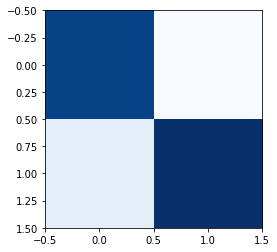

In [8]:
# Matrice di confusione
print("Matrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

<font size=3>

Ai fini di migliorare le performance classificative si estende la ricerca dei parametri ottimali non sono al modello di classificazione ma anche alla costruzione delle features. Nell'esempio sono utilizzate due ulteriori condizioni:
* <b>values</b>: una lista contenente valori che saranno passati all'algoritmo di LBP
* <b>words</b>: una lista con il numero di cluster da utilizzare
<br></br>

Le proporzioni fra numero di punti e gli altri parametri della LBP vengono tenute costanti rispetto alla classificazione fatta in precedenza. Per l'algoritmo SVC viene provato anche un kernel lineare, ovvero una decision boundary rappresentata da una retta. I risultati sono salvati in un <i>dataframe pandas</i> e successivamente verrà ordianto per valori descrescenti di <b>weighted avg f1-score</b>. 

In [9]:
import warnings
warnings.filterwarnings("ignore")

values = [12, 24, 36]
words = [100, 200, 300]
df = pd.DataFrame(columns=['P', 'shift', 'size', 'words', 'C', 'gamma', 'kernel', 'precision', 'recall', 'f1-score'])

for value in tqdm(values):
    P = value
    R = y_shift = x_shift = int(P/3)
    size = y_shift * 2
    
    X_train, X_test, y_train, y_test = load_data(feature_extractor=lambda x:
                                                    lbp_features(x, P=P, R=R, y_shift=y_shift, 
                                                                 x_shift=x_shift, size=size), 
                                                 maximages=500)
    
    
    for word in words:
        X_train2, X_test2 = bow(X_train, X_test, nwords=word)
        
        param_grid = {'C': [0.5, 1, 1.5, 2, 5, 10],
                      'gamma': [0.1, 1, 10, 100, 300, 500],
                      'kernel': ['rbf', 'linear']}
        clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5, n_jobs=-1)
        clf = clf.fit(X_train2, y_train)
        y_pred = clf.predict(X_test2)
        
        classification = classification_report(y_test, y_pred, output_dict=True)
        classification = classification["weighted avg"]
                
        df.loc[len(df)] = [P, y_shift, size, word, clf.best_estimator_.C, clf.best_estimator_.gamma,
                           clf.best_estimator_.kernel, classification["precision"], classification["recall"],
                           classification["f1-score"]]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [45:46<00:00, 1059.19s/it]


In [10]:
df.sort_values(by=['f1-score'], ascending=False)

,P,shift,size,words,C,gamma,kernel,precision,recall,f1-score
6,36,12,24,100,10,10,rbf,0.746656,0.746667,0.746362
7,36,12,24,200,1.5,100,rbf,0.736972,0.736667,0.736746
4,24,8,16,200,1.5,100,rbf,0.738151,0.736667,0.736746
3,24,8,16,100,5,100,rbf,0.727467,0.726667,0.726776
2,12,4,8,300,1.5,500,rbf,0.718665,0.716667,0.716701
5,24,8,16,300,2,300,rbf,0.713791,0.713333,0.713435
8,36,12,24,300,1.5,100,rbf,0.700462,0.700000,0.700107
0,12,4,8,100,5,100,rbf,0.696756,0.696667,0.696704
1,12,4,8,200,10,300,rbf,0.656765,0.656667,0.656709


Matrice di confusione:
[[103  41]
 [ 32 124]]


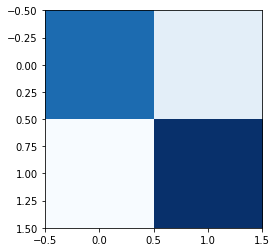

In [15]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=lambda x:
                                                    lbp_features(x, P=36, R=12, y_shift=12, 
                                                                 x_shift=12, size=24), 
                                                 maximages=500)
X_train2, X_test2 = bow(X_train, X_test, nwords=100)
best_clf = SVC(kernel='rbf', gamma=10, C=5, class_weight='balanced')

best_clf = best_clf.fit(X_train2, y_train)
y_pred = best_clf.predict(X_test2)


# Matrice di confusione
print("Matrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)